In [1]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import empyrical as em  # most likely you will need to pip install this
from IPython.core.display import display, HTML
import numpy as np
from IPython.display import HTML

### Example close price df:
![close price df](close_price_df.png)

### Example port_value series:
![port_value_df](port_value.PNG)

In [2]:
def performance_eval(port_values, close_prices, initial_cash):
    '''
    Input: 1) A time series of portfolio value at end of day (close price * quantity)
           Please make sure the time index is in datetime format and excludes time 
           i.e. 2017-07-14 (you can use dt.date to extract the date)
           check above example
           
           2) A dataframe of close price at end of day (check above example)
 
    
    '''
    
    bdays_per_year = 256
    bdays_per_month = 20
    rolling_window = 20
    
    # resample to daily data
    close_prices['close_time'] = pd.to_datetime(close_prices['close_time'])
    close_prices = close_prices.resample('D', on='close_time').last()
    close_prices.index = close_prices.index.date
    close_prices = close_prices.drop(columns = ['close_time'])
    
    # make sure both time series are in the same time period
    close_prices = close_prices.reindex(port_values.index).ffill()
    
    yearly_pect_rtn = em.aggregate_returns(port_values.pct_change(), "yearly")
    monthly_pect_rtn = em.aggregate_returns(port_values.pct_change(), "monthly")
    
    annulized_rtn = np.power((port_values[-1] / initial_cash), (365/len(port_values))) - 1 
    
    accum_rtn = (port_values[-1] - initial_cash) / initial_cash
    
    # calculate sharpe ratio
    sqrt_bdays_per_year = int(np.sqrt(bdays_per_year))

    sharpe_ratio = (port_values.pct_change().mean() * bdays_per_year) / \
                        (port_values.pct_change().std() * sqrt_bdays_per_year)
    
    # calculate drawdowns
    drawdowns = (port_values / port_values.cummax()) - 1
    max_drawdown = drawdowns.iloc[(-np.abs(drawdowns.values)).argsort()][0]
    
    # calculate volatility
    daily_vola = close_prices['close'].diff().std()
    annualized_vola = np.sqrt(bdays_per_year) * daily_vola
    
    strategy_perc_returns = port_values.diff() / port_values.shift(1)
    strategy_cum_returns = strategy_perc_returns.cumsum()
    
    
    # plotting
    metric = pd.DataFrame(data={}, columns=["Backtest"], index=['Annualized Return', 'Cumulative Returns', 'Annual volatility',
                                                               'Sharpe Ratio', 'Max Drawdown'])


    metric.loc["Annualized Return", "Backtest"] = str(f'{annulized_rtn*100:.2f}%')
    metric.loc["Cumulative Returns", "Backtest"] = str(f'{accum_rtn*100:.2f}%')
    metric.loc["Annual volatility", "Backtest"] = str(f'{annualized_vola*100:.2f}%')
    metric.loc["Sharpe Ratio", "Backtest"] = str(f'{sharpe_ratio:.2f}')
    metric.loc["Max Drawdown", "Backtest"] = str(f'{max_drawdown*100:.2f}%')
    print(f"Start Date : {port_values.index[0]} ")
    print(f"End Date : {port_values.index[-1]} ")
    display(metric)

    plt.style.use('seaborn-talk')

    fig = plt.figure(figsize=(12, 15))
    ax = fig.add_subplot(511)
    ax.set_title('Equity Curve')
    ax.plot(port_values, linestyle='-', label='Equity Curve', linewidth=3.0, color='g')
    ax.grid(True)
    ax.set_xlim(port_values.index[0], port_values.index[-1])

    ax = fig.add_subplot(513)
    ax.set_title('Drawdowns')
    ax.fill_between(port_values.index,drawdowns,label = 'Drawdown', linestyle='-', linewidth=2.0, color='b')
    ax.grid(True)
    ax.set_xlim(port_values.index[0], port_values.index[-1])

    ax = fig.add_subplot(512)
    ax.set_title('Cumulative Returns')
    ax.plot(strategy_cum_returns, label='Cumulative Returns', linestyle='-', linewidth=3.0, color='g')
    ax.grid(True)
    ax.set_xlim(port_values.index[0], port_values.index[-1])

    ax = fig.add_subplot(514)
    rolling_vola = port_values.pct_change().rolling(rolling_window).std() # monthly
    ax.set_title(f'Rolling Volatility ({rolling_window} days)')
    ax.plot(rolling_vola, label=f'Rolling Volatility ({rolling_window} days)', linestyle='-', linewidth=2.0, color='orange')
    # ax.legend()
    ax.grid(True)
    ax.set_xlim(port_values.index[0], port_values.index[-1])

    ax = fig.add_subplot(515)
    rolling_return = port_values.pct_change().rolling(rolling_window).mean() # monthly
    rolling_sharpe = rolling_return / rolling_vola
    ax.set_title(f'Rolling Sharpe Ratio ({rolling_window} days)')
    ax.plot(rolling_sharpe, label=f'Rolling Sharpe Ratio ({rolling_window} days)', linestyle='-', linewidth=2.0,color='orange')
    # ax.legend()
    ax.grid(True)
    ax.set_xlim(port_values.index[0], port_values.index[-1])
    fig.tight_layout();
    
    # create time return table
    table = """
    <table class='table table-hover table-condensed table-striped'>
    <thead>
    <tr>
    <th style="text-align:right">Year</th>
    <th style="text-align:right">Jan</th>
    <th style="text-align:right">Feb</th>
    <th style="text-align:right">Mar</th>
    <th style="text-align:right">Apr</th>
    <th style="text-align:right">May</th>
    <th style="text-align:right">Jun</th>
    <th style="text-align:right">Jul</th>
    <th style="text-align:right">Aug</th>
    <th style="text-align:right">Sep</th>
    <th style="text-align:right">Oct</th>
    <th style="text-align:right">Nov</th>
    <th style="text-align:right">Dec</th>
    <th style="text-align:right">Year</th>
    </tr>
    </thead>
    <tbody>
    <tr>"""

    first_year = True
    first_month = True
    yr = 0
    mnth = 0
    for m, val in monthly_pect_rtn.iteritems():
        yr = m[0]
        mnth = m[1]

        if first_month:
            table += "<td align='right'><b>{}</b></td>\n".format(yr)
            first_month = False

        if first_year:  # pad empty months for first year if sim doesn't start in January
            first_year = False
            if mnth > 1:
                for i in range(1, mnth):
                    table += "<td align='right'>-</td>\n"

        table += "<td align='right'>{:+.1f}</td>\n".format(val * 100)

        if mnth == 12:  # check for dec, add yearly
            table += "<td align='right'><b>{:+.1f}</b></td>\n".format(yearly_pect_rtn[yr] * 100)
            table += "</tr>\n <tr> \n"
            first_month = True

    # add padding for empty months and last year's value
    if mnth != 12:
        for i in range(mnth + 1, 13):
            table += "<td align='right'>-</td>\n"
            if i == 12:
                table += "<td align='right'><b>{:+.1f}</b></td>\n".format(
                    yearly_pect_rtn[yr] * 100
                )
                table += "</tr>\n <tr> \n"
    table += "</tr>\n </tbody> \n </table>"

    print("\033[1m" + "Time Returns (monthly %)" + "\033[0m")
    display(HTML(table))
    
    
    # create holding period analysis
    df = pd.DataFrame(columns=range(1,len(monthly_pect_rtn)+1), index=[monthly_pect_rtn.index[0][0]])

    month_start = 0

    table = "<table class='table table-hover table-condensed table-striped'>"
    table += "<tr><th>Months</th>"

    for i in range(len(monthly_pect_rtn)):
        table += "<th>{}</th>".format(i+1)
    table += "</tr>"

    # get unique years
    monthly_index_set = set()
    for y, m in monthly_pect_rtn.index:
        if not y in monthly_index_set:
            monthly_index_set.add(y)

    years_unique = list(monthly_index_set)

    for y in years_unique: # Iterates years
        table += "<tr><th>{}</th>".format(y) # New table row

        for month_held in (range(1, len(monthly_pect_rtn)+1)):
            if month_held <= len(monthly_pect_rtn[month_start:month_start + month_held]):
                rtn = em.annual_return(monthly_pect_rtn[month_start:month_start + month_held], 'monthly' )
                table += "<td>{:+.0f}</td>".format(rtn * 100)

        table += "</tr>"   
        month_start += 1
    print("\033[1m" + "Holding Period Returns (%)" + "\033[0m")
    display(HTML(table))


## Example

In [3]:
# df_2019 = pd.read_csv("ML_momentum_2019.csv")
# df_2019['period_open'] = pd.to_datetime(df_2019['period_open'])
# df_2019 = df_2019.set_index(df_2019['period_open'].dt.date)
# df_2019.head()

# port_values = df_2019['portfolio_value']
# port_values


df = pd.read_csv("NM_ETHBTC_RandomForest_1.47_2020.csv")
df['open_time'] = pd.to_datetime(df['open_time'])
df = df.set_index(df['open_time'].dt.date)
port_values = df['total_value']
port_values

open_time
2020-01-01      1.000000
2020-01-02      1.007451
2020-01-03      1.012540
2020-01-04      1.018098
2020-01-05      1.018098
                 ...    
2020-12-27    510.329233
2020-12-28    539.878736
2020-12-29    556.055810
2020-12-30    576.707061
2020-12-31    593.469804
Name: total_value, Length: 366, dtype: float64

In [4]:
#close_prices = pd.read_csv("0_klines_ETHBTC_1m.csv")[['close_time', 'close']]
close_prices = pd.read_pickle('../playground/nicks/data/candlestick_15m_ETHBTC_2107291134.pkl').reset_index()[['close_time','close']]
close_prices.head()

,close_time,close
0,2017-07-14 04:14:59.999,0.086400
1,2017-07-14 04:29:59.999,0.085811
2,2017-07-14 04:44:59.999,0.086314
3,2017-07-14 04:59:59.999,0.086347
4,2017-07-14 05:14:59.999,0.084680


Start Date : 2020-01-01 
End Date : 2020-12-31 


,Backtest
Annualized Return,58220.47%
Cumulative Returns,59246.98%
Annual volatility,1.25%
Sharpe Ratio,11.98
Max Drawdown,-0.44%


Time Returns (monthly %)


Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,Year
2020,+50.2,+91.2,+134.7,+35.4,+43.9,+25.6,+31.8,+94.0,+127.7,+48.0,+89.6,+120.2,+59247.0


Holding Period Returns (%)


Months,1,2,3,4,5,6,7,8,9,10,11,12
2020,+13075,+56029,+206515,+76028,+48308,+27134,+19513,+27290,+43874,+38209,+44736,+59247


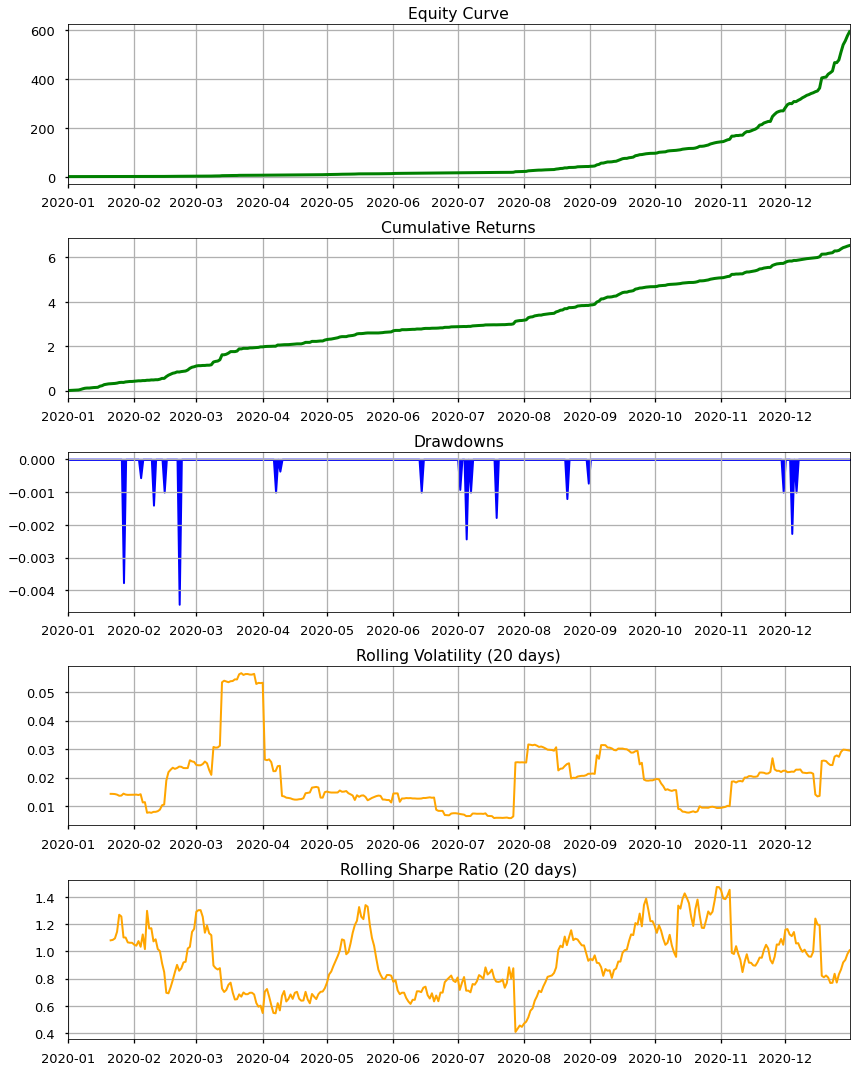

In [5]:
performance_eval(port_values, close_prices, 1)